This is my attempt at trying MADGICS again on the two moons dataset, but after applying a normalizing flow to make the data Gaussian. Then, I use another normalizing flow to transform back into the original data space, and take a look at the components.

## Normalizing flow: Two moon to Gaussian

The code below was modified by that written by karpathy available at https://github.com/karpathy/pytorch-normalizing-flows/tree/master.

In [ ]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow,
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from spline_flows import NSF_AR, NSF_CL

# # for auto-reloading external modules
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

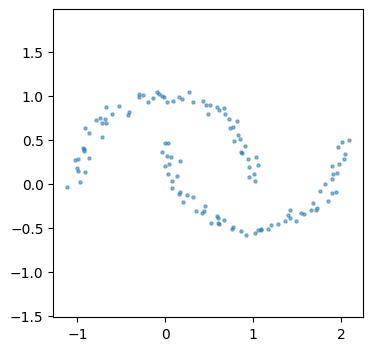

In [ ]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetSIGGRAPH:
    """
    haha, found from Eric https://blog.evjang.com/2018/01/nf2.html
    https://github.com/ericjang/normalizing-flows-tutorial/blob/master/siggraph.pkl
    """
    def __init__(self):
        with open('siggraph.pkl', 'rb') as f:
            XY = np.array(pickle.load(f), dtype=np.float32)
            XY -= np.mean(XY, axis=0) # center
        self.XY = torch.from_numpy(XY)

    def sample(self, n):
        X = self.XY[np.random.randint(self.XY.shape[0], size=n)]
        return X

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

d = DatasetMoons()
#d = DatasetMixture()
#d = DatasetSIGGRAPH()

x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [ ]:
# construct a model
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution

# RealNVP
# flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]

# NICE
# flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(4)]
# flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(4)]

# MAF (with MADE net, so we get very fast density estimation)
# flows = [MAF(dim=2, parity=i%2) for i in range(4)]

# IAF (with MADE net, so we get very fast sampling)
# flows = [IAF(dim=2, parity=i%2) for i in range(3)]

# insert ActNorms to any of the flows above
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, flows)))

# Glow paper
# flows = [Invertible1x1Conv(dim=2) for i in range(3)]
# norms = [ActNorm(dim=2) for _ in flows]
# couplings = [AffineHalfFlow(dim=2, parity=i%2, nh=32) for i in range(len(flows))]
# flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1

# Neural splines, coupling
nfs_flow = NSF_CL if True else NSF_AR
flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
convs = [Invertible1x1Conv(dim=2) for _ in flows]
norms = [ActNorm(dim=2) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# construct the model


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:738: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1992.)
  LU, pivots, infos = torch._lu_with_info(


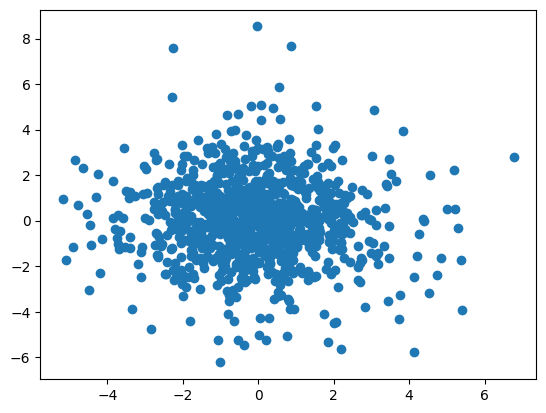

In [ ]:
p = prior.sample((1000,))
plt.plot(p[:,0], p[:,1], 'o')

In [65]:
model = NormalizingFlowModel(prior, flows)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

model.train()
for k in range(2000):
    x = d.sample(128)

    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())


number of params:  5844
58.73423767089844
54.783145904541016
52.67355728149414
54.58549118041992
52.587806701660156
51.271358489990234
57.29209899902344
51.51518630981445
54.25437927246094
48.60942840576172
58.0524787902832
50.44145965576172
57.8427734375
56.929351806640625
50.50939178466797
52.62143325805664
62.52885055541992
53.93739700317383
51.814083099365234
53.782630920410156


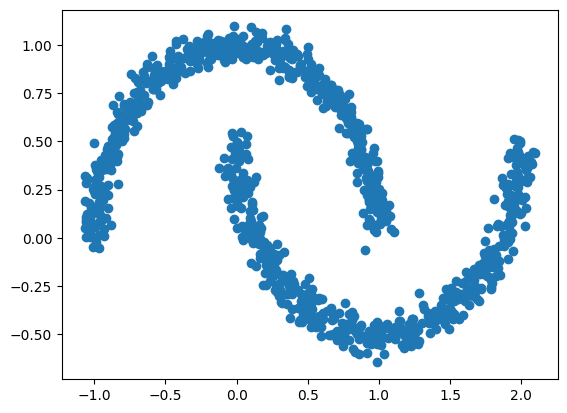

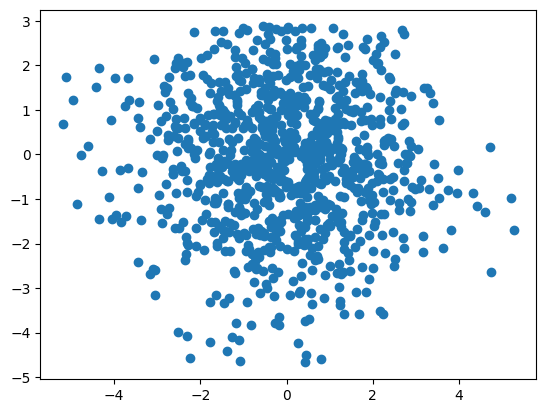

In [66]:
data_tensor = d.sample(1000)
data_numpy = data_tensor.numpy()
plt.plot(data_numpy[:,0],data_numpy[:,1], 'o')
plt.show()

model.eval()

zs, prior_logprob, log_det = model(data_tensor)
output = zs[-1].detach().numpy()
plt.plot(output[:,0], output[:,1], 'o')

In [67]:
data_tensor.shape

torch.Size([1000, 2])

In [59]:
def twomoon_to_gaussian(two_moon_data):
  zs, prior_logprob, log_det = model(two_moon_data)
  output = zs[-1].detach().numpy()
  return output

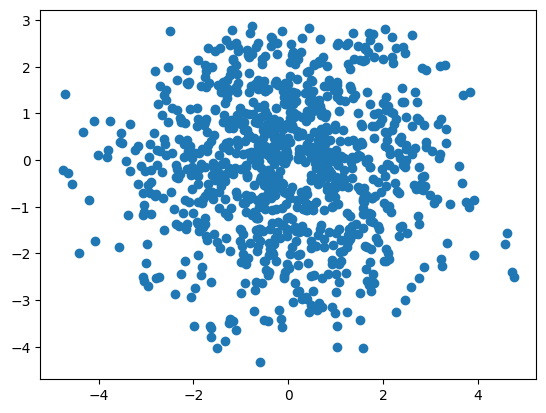

In [61]:
model.eval()

zs, prior_logprob, log_det = model(data_tensor)
output = zs[-1].detach().numpy()
plt.plot(output[:,0], output[:,1], 'o')

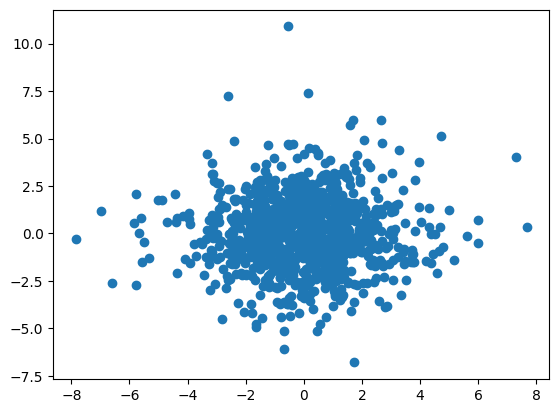

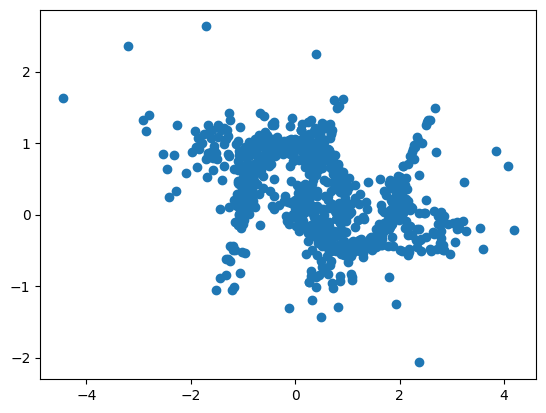

In [ ]:
samples = model.sample(128*8)[0]
plt.plot(samples[:,0], samples[:,1], 'o')
plt.show()
samples = model.sample(128*8)[-1].detach().numpy()
plt.plot(samples[:,0], samples[:,1], 'o')
plt.show()

Text(0.5, 1.0, 'z -> x')

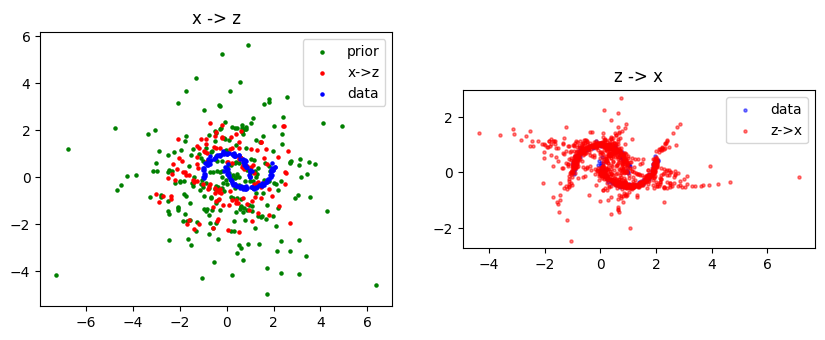

In [ ]:
model.eval()

x = d.sample(128)
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

zs = model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

## Normalizing flow: Gaussian to two moon

The code below was modified from that written by Eric Jang available at https://blog.evjang.com/2019/07/nf-jax.html

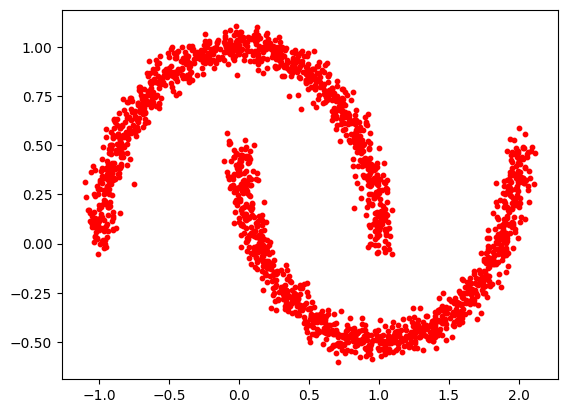

In [ ]:
import jax.numpy as np
from jax import random
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu # neural network layers
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
# X = StandardScaler().fit_transform(X)
# xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
# plt.xlim(xlim)
# plt.ylim(ylim)

In [ ]:
rng = random.PRNGKey(0)

def sample_n01(N):
  D = 2
  return random.normal(rng, (N, D))

def log_prob_n01(x):
  return np.sum(-np.square(x)/2 - np.log(np.sqrt(2*np.pi)),axis=-1)

In [ ]:
def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
  d = x.shape[-1]//2
  x1, x2 = x[:, :d], x[:, d:]
  if flip:
    x2, x1 = x1, x2
  shift, log_scale = shift_and_log_scale_fn(net_params, x1)
  y2 = x2*np.exp(log_scale) + shift
  if flip:
    x1, y2 = y2, x1
  y = np.concatenate([x1, y2], axis=-1)
  return y

In [ ]:
def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
  d = y.shape[-1]//2
  y1, y2 = y[:, :d], y[:, d:]
  if flip:
    y1, y2 = y2, y1
  shift, log_scale = shift_and_log_scale_fn(net_params, y1)
  x2 = (y2-shift)*np.exp(-log_scale)
  if flip:
    y1, x2 = x2, y1
  x = np.concatenate([y1, x2], axis=-1)
  return x, log_scale

In [ ]:
def init_nvp():
  D = 2
  net_init, net_apply = stax.serial(
    Dense(512), Relu, Dense(512), Relu, Dense(D))
  in_shape = (-1, D//2)
  out_shape, net_params = net_init(rng, in_shape)
  def shift_and_log_scale_fn(net_params, x1):
    s = net_apply(net_params, x1)
    return np.split(s, 2, axis=1)
  return net_params, shift_and_log_scale_fn

def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
  x = base_sample_fn(N)
  return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
  x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
  ildj = -np.sum(log_scale, axis=-1)
  return base_log_prob_fn(x) + ildj

In [ ]:
def init_nvp_chain(n=2):
  flip = False
  ps, configs = [], []
  for i in range(n):
    p, f = init_nvp()
    ps.append(p), configs.append((f, flip))
    flip = not flip
  return ps, configs

def sample_nvp_chain(ps, configs, base_sample_fn, N):
  x = base_sample_fn(N)
  for p, config in zip(ps, configs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  return x

def make_log_prob_fn(p, log_prob_fn, config):
  shift_log_scale_fn, flip = config
  return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
  log_prob_fn = base_log_prob_fn
  for p, config in zip(ps, configs):
    log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
  return log_prob_fn(y)

In [ ]:
ps, cs = init_nvp_chain(8)
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

In [38]:
from jax.example_libraries import optimizers
from jax import jit, grad
import numpy as onp
ps, cs = init_nvp_chain(4)

def loss(params, batch):
  return -np.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

@jit
def step(i, opt_state, batch):
  params = get_params(opt_state)
  g = grad(loss)(params, batch)
  return opt_update(i, g, opt_state)

iters = int(1e4)
# data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))
data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))

opt_state = opt_init(ps)
for i in range(iters):
  opt_state = step(i, opt_state, next(data_generator))
ps = get_params(opt_state)

In [83]:
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

In [84]:
x = sample_n01(1000)
values = [x]
for p, config in zip(ps, cs):
  shift_log_scale_fn, flip = config
  x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  values.append(x)

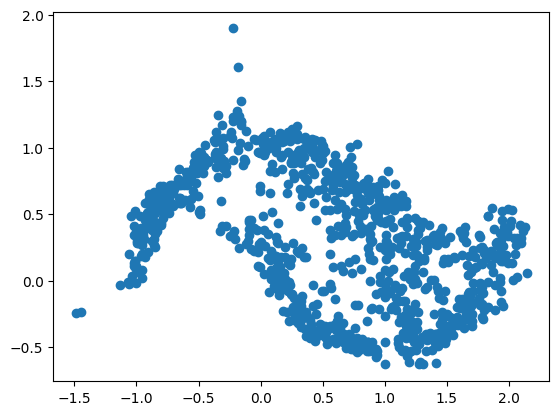

In [85]:
plt.plot(*values[-1].T, 'o')

In [42]:
def gaussian_to_two_moon(x):
  values = [x]
  for p, config in zip(ps, cs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
    values.append(x)
  return values[-1]

# Applying MADGICS

Below is where I actually try to do MADGICS with the two moons in a transformed space.

In [43]:
noisy_moons = datasets.make_moons(n_samples=5000, noise=.05)
X, y = noisy_moons
# X = StandardScaler().fit_transform(X).T

one_moon = X[y==0].T
other_moon = X[y==1].T

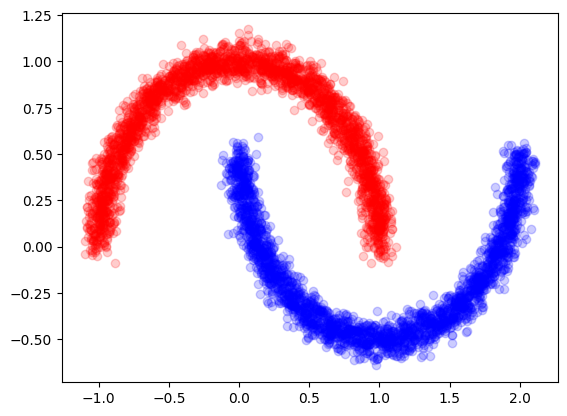

In [44]:
plt.plot(*one_moon, 'ro', alpha = 0.2)
plt.plot(*other_moon, 'bo', alpha = 0.2)

In [45]:
combined_data = one_moon + other_moon

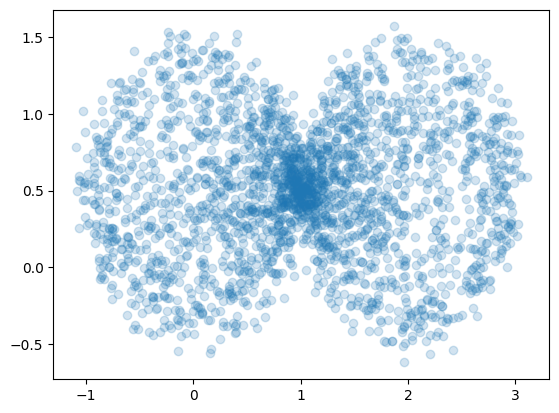

In [46]:
plt.plot(*combined_data, 'o', alpha = 0.2)

In [47]:
combined_data_tensor = torch.tensor(combined_data)
combined_data_tensor.shape

torch.Size([2, 2500])

In [48]:
# def twomoon_to_gaussian(two_moon_data):
#   zs, prior_logprob, log_det = model(two_moon_data)
#   output = zs[-1].detach().numpy()
#   return output

Transform combined data into Gaussian space

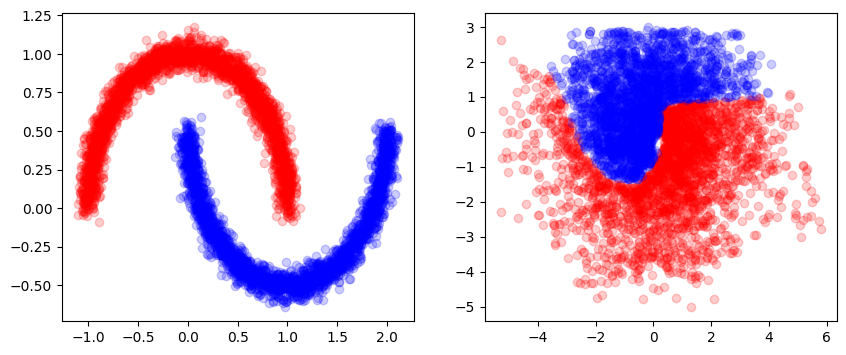

In [90]:
transformed_one_moon = twomoon_to_gaussian(torch.tensor(one_moon).T.float())
transformed_other_moon = twomoon_to_gaussian(torch.tensor(other_moon).T.float())

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(*one_moon, 'ro', alpha = 0.2)
ax[0].plot(*other_moon, 'bo', alpha = 0.2)

ax[1].plot(*transformed_one_moon.T, 'ro', alpha = 0.2)
ax[1].plot(*transformed_other_moon.T, 'bo', alpha = 0.2)

fig.savefig("normflow.pdf", bbox_inches='tight')

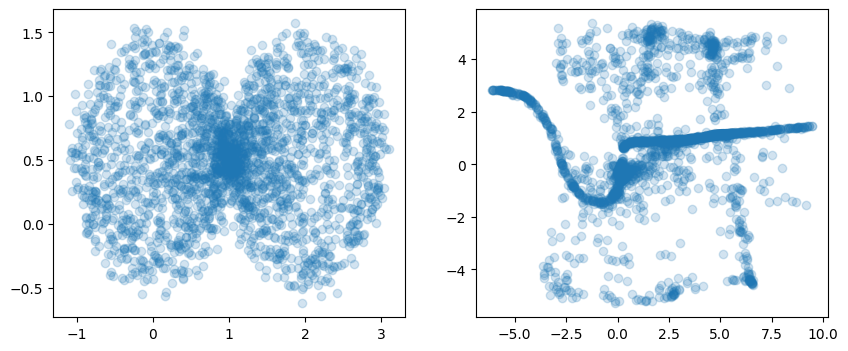

In [82]:
transformed_combined_data = twomoon_to_gaussian(combined_data_tensor.T.float())
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(*combined_data, 'o', alpha = 0.2)
ax[1].plot(*transformed_combined_data.T, 'o', alpha = 0.2)

fig.savefig("combined.pdf", bbox_inches='tight')

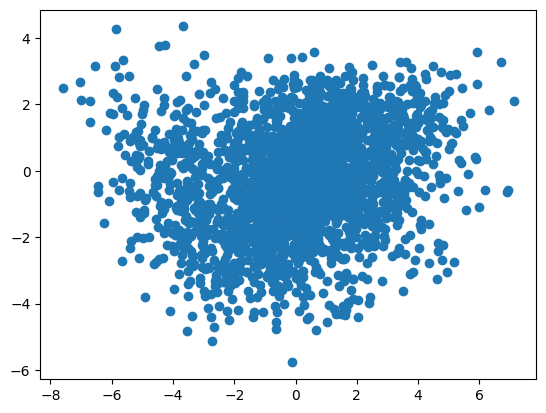

In [70]:
plt.plot(*(transformed_one_moon + transformed_other_moon).T, 'o')

In [71]:
len(transformed_one_moon)

2500

Attempt to apply MADGICS

In [72]:
one_moon_cov = np.matmul(transformed_one_moon.T, transformed_one_moon) / len(transformed_one_moon)
other_moon_cov = np.matmul(transformed_other_moon.T, transformed_other_moon) / len(transformed_other_moon)
one_moon_cov, other_moon_cov

(Array([[ 3.8663778 , -0.18694815],
        [-0.18694815,  2.9578457 ]], dtype=float32),
 Array([[1.7348152 , 0.05004708],
        [0.05004708, 1.7633748 ]], dtype=float32))

In [73]:
Ctotinv = np.linalg.inv(one_moon_cov + other_moon_cov)
recovered_one_moon = np.matmul(np.matmul(one_moon_cov, Ctotinv), transformed_combined_data.T)
recovered_other_moon = np.matmul(np.matmul(other_moon_cov, Ctotinv), transformed_combined_data.T)

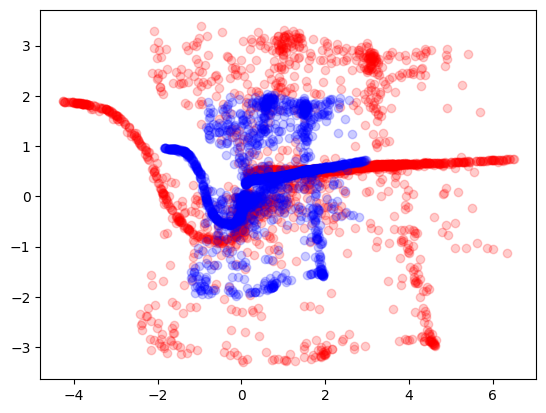

In [86]:
plt.plot(*recovered_one_moon, 'ro', alpha = 0.2)
plt.plot(*recovered_other_moon, 'bo', alpha = 0.2)

Convert recovered components back to data space

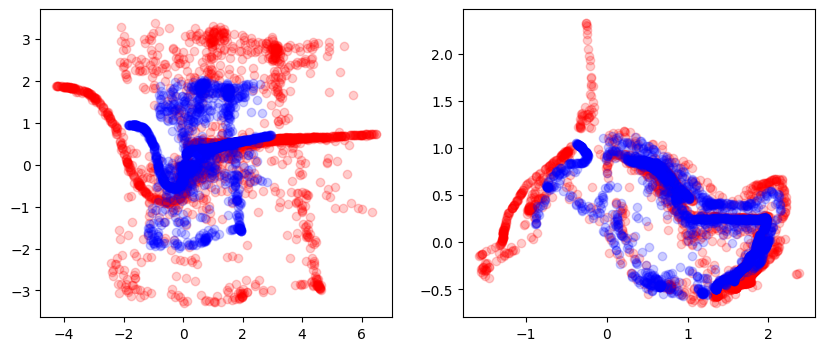

In [89]:
one_moon_final = gaussian_to_two_moon(recovered_one_moon.T)
other_moon_final = gaussian_to_two_moon(recovered_other_moon.T)

fig, ax = plt.subplots(1,2, figsize=(10,4))


ax[0].plot(*recovered_one_moon, 'ro', alpha = 0.2)
ax[0].plot(*recovered_other_moon, 'bo', alpha = 0.2)


ax[1].plot(*one_moon_final.T, 'ro', alpha = 0.2)
ax[1].plot(*other_moon_final.T, 'bo', alpha = 0.2)

fig.savefig("recovered.pdf", bbox_inches='tight')

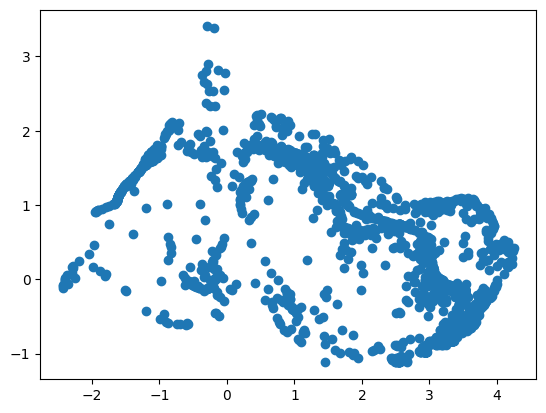

In [76]:
plt.plot(*(one_moon_final.T + other_moon_final.T), 'o')